In [1]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
lr = 1e-3
epoch = 50
batch_size = 100
lambda_l2_reg = 1e-5

In [3]:
import tensorflow as tf
import numpy as np
import copy
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [4]:
initializer_b = tf.keras.initializers.zeros()
initializer_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

$$\begin{array}{cccccccccccccccccccccccccccc}
x&\stackrel{\varphi(xw_1+b_1)}{\Rightarrow}&
x_1&\stackrel{\varphi(x_1w_2^\mu+b_2^\mu)}{\Rightarrow}&
\mu&\stackrel{\varphi(zw_3+b_3)}{\Rightarrow}&
x_3&\stackrel{x_3w_4+b_4}{\Rightarrow}&\mbox{logits}\\
&&&\stackrel{\varphi(x_1w_2^{\log\sigma^2}+b_2^{\log\sigma^2})}{\Rightarrow}&
\log\sigma^2&&&\stackrel{\sigma(\mbox{logits})}{\Rightarrow}&x_{recon}\\
&&&\stackrel{\mu+e^{\frac{1}{2}\log\sigma^2}N(0,1^2)}{\Rightarrow}&
z\\
(?, 784)&&(?, 100)&&(?, 16)&&(?, 100)&&(?, 784)\\ 
\end{array}$$

```
x.shape = (?, 784) 
x.dtype = tf.float32 
```

In [5]:
x = tf.placeholder(tf.float32, (None, 784)) 

```
x1.shape = (?, 100)  # (?, 100) = (?, 784) @ (784, 100) + (100,) 
x1.dtype = tf.float32 
```

In [6]:
w1 = tf.get_variable("w1", [784, 100], tf.float32, initializer_w) 
b1 = tf.get_variable("b1", [100,], tf.float32, initializer_b) 
x1 = tf.nn.relu(x@w1+b1) 

```
mu.shape = (?, 16)  # (?, 100) = (?, 100) @ (100, 16) + (16,) 
mu.dtype = tf.float32 

log_var.shape = (?, 16)  # (?, 100) = (?, 100) @ (100, 16) + (16,) 
log_var.dtype = tf.float32

z.shape = (?, 16)  
z.dtype = tf.float32
```

In [7]:
w2_mu = tf.get_variable("w2_mu", [100, 16], tf.float32, initializer_w) 
b2_mu = tf.get_variable("b2_mu", [16,], tf.float32, initializer_b) 
mu = tf.nn.relu(x1@w2_mu+b2_mu) 

w2_log_var = tf.get_variable("w2_log_var", [100, 16], tf.float32, initializer_w) 
b2_log_var = tf.get_variable("b2_log_var", [16,], tf.float32, initializer_b) 
log_var = tf.nn.relu(x1@w2_log_var+b2_log_var) 

z = mu + tf.exp(log_var / 2) * tf.random_normal(shape=tf.shape(mu))

```
x3.shape = (?, 100)  # (?, 100) = (?, 16) @ (16, 100) + (100,) 
x3.dtype = tf.float32 
```

In [8]:
w3 = tf.get_variable("w3", [16, 100], tf.float32, initializer_w) 
b3 = tf.get_variable("b3", [100,], tf.float32, initializer_b)
x3 = tf.nn.relu(z@w3+b3)

```
x_recon.shape = (?, 784)  # (?, 784) = (?, 100) @ (100, 784) + (784,) 
x_recon.dtype = tf.float32 
```

In [9]:
w4 = tf.get_variable("w4", [100, 784], tf.float32, initializer_w) 
b4 = tf.get_variable("b4", [784,], tf.float32, initializer_b)
logits = x3@w4+b4
x_recon = tf.nn.sigmoid(logits)

```
l2.shape = (?,)  # (?,) 
l2.dtype = tf.float32 

loss.shape = ()  # () 
loss.dtype = tf.float32 
```

In [10]:
recon = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x)
recon_loss = tf.reduce_sum(recon, axis=1)
kl = tf.exp(log_var) + mu**2 - 1. - log_var
kl_loss = 0.5 * tf.reduce_sum(kl, axis=1)
l2_loss_w = [tf.nn.l2_loss(var)
             for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
             if "w" in var.name]
l2_loss = lambda_l2_reg * tf.add_n(l2_loss_w)
loss = tf.reduce_mean(recon_loss + kl_loss + l2_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [12]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    loss_trace = []

    for i in range(epoch):
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        x_epoch = x_train[idx]
        for k in range(x_train.shape[0]//batch_size):
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            feed_dict = {x:x_batch}
            loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
    
    feed_dict = {x:x_test[:10]}
    x_test_z, x_test_recon = sess.run([z, x_recon], feed_dict=feed_dict)
    
    z_random = np.random.normal(size=(10, 16))
    feed_dict = {z:z_random}
    random_recon = sess.run(x_recon, feed_dict=feed_dict)
    
    x_lattice = np.linspace(-3, 3, 10)
    y_lattice = np.linspace(-3, 3, 10)
    x_lattice, y_lattice = np.meshgrid(x_lattice, y_lattice)
    x_lattice, y_lattice = x_lattice.reshape((-1,)), y_lattice.reshape((-1,))
    x_lattice, y_lattice = x_lattice.astype(np.float32), y_lattice.astype(np.float32)
    z_lattice = np.zeros((100, 16))
    lattice_recon = []
    for i in range(15):
        z_lattice[:,i] = x_lattice 
        z_lattice[:,i+1] = y_lattice 
        feed_dict = {z:z_lattice}
        lattice_recon_temp = sess.run(x_recon, feed_dict=feed_dict)
        lattice_recon.append(lattice_recon_temp)

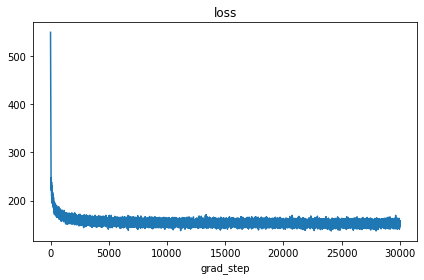

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(loss_trace)
ax.set_title('loss')
ax.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

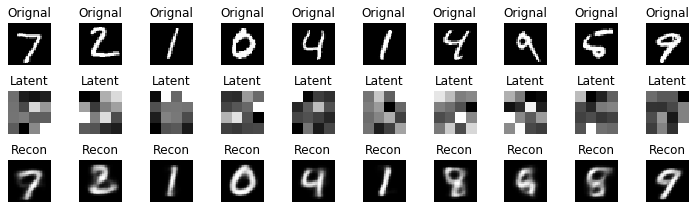

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(3):
    for k in range(10):
        if i==0:
            axes[i,k].imshow(x_test[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Orignal')
        elif i==1:
            axes[i,k].imshow(x_test_z[k].reshape((4,4)), cmap=plt.cm.gray)
            axes[i,k].set_title('Latent')
        else:
            axes[i,k].imshow(x_test_recon[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Recon')
        axes[i,k].axis('off')
plt.tight_layout()
plt.show()

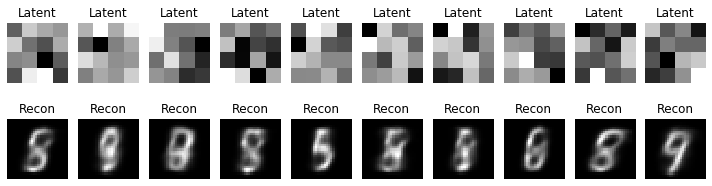

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 10, figsize=(10,3))
for i in range(2):
    for k in range(10):
        if i==0:
            axes[i,k].imshow(z_random[k].reshape((4,4)), cmap=plt.cm.gray)
            axes[i,k].set_title('Latent')
        else:
            axes[i,k].imshow(random_recon[k].reshape((28,28)), cmap=plt.cm.gray)
            axes[i,k].set_title('Recon')
        axes[i,k].axis('off')
plt.tight_layout()
plt.show()

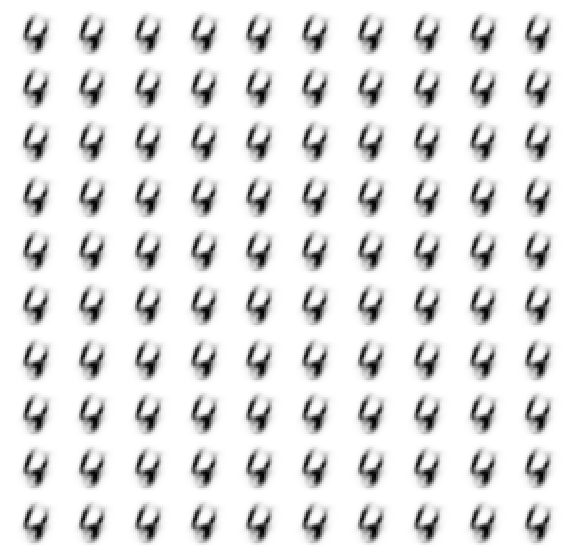

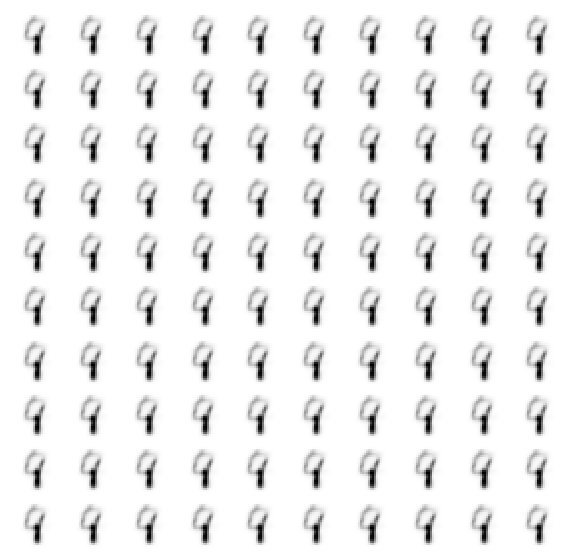

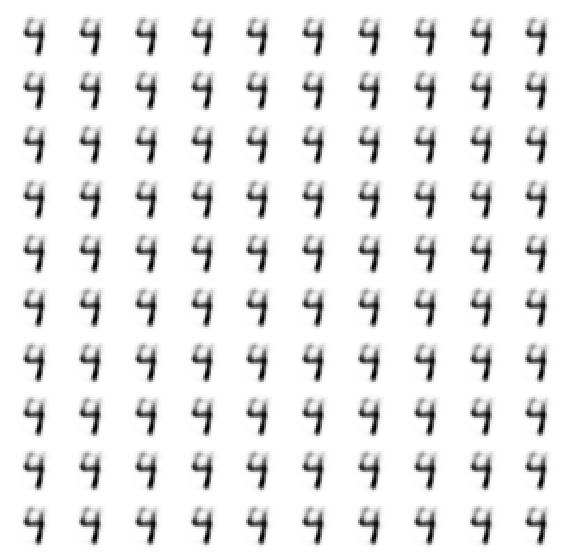

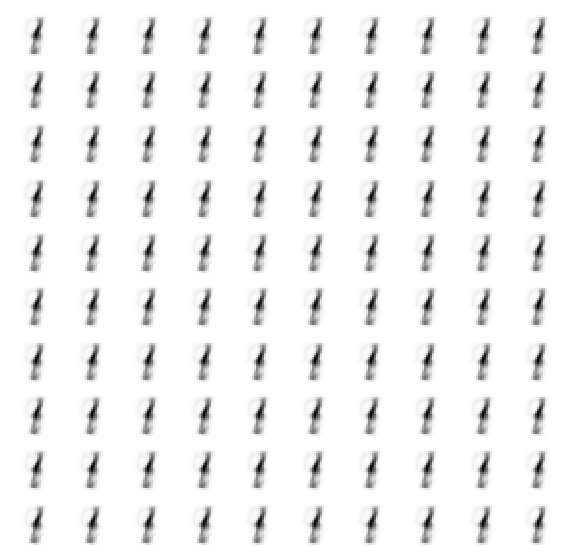

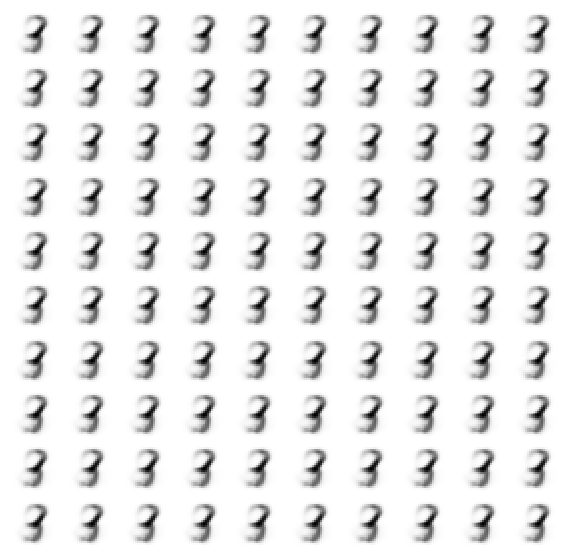

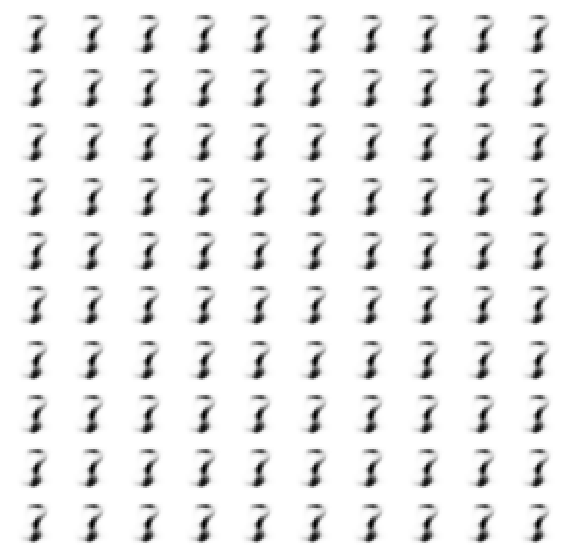

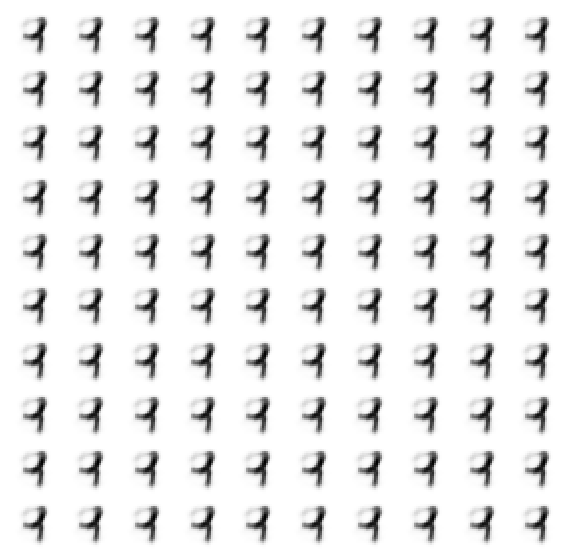

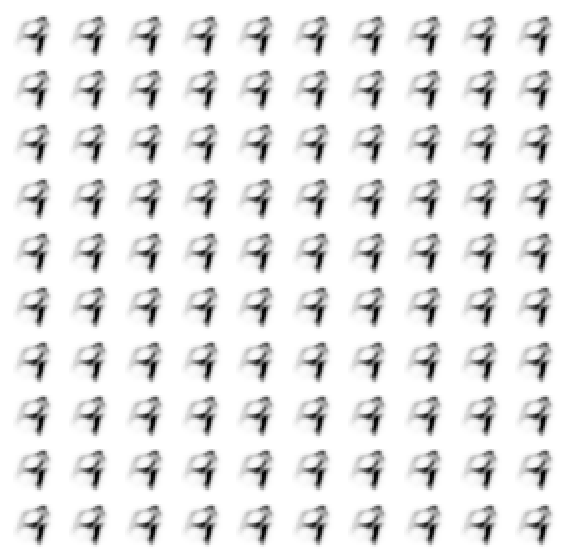

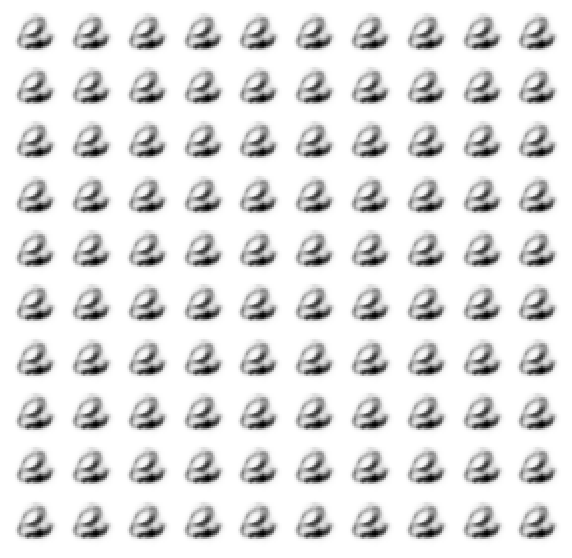

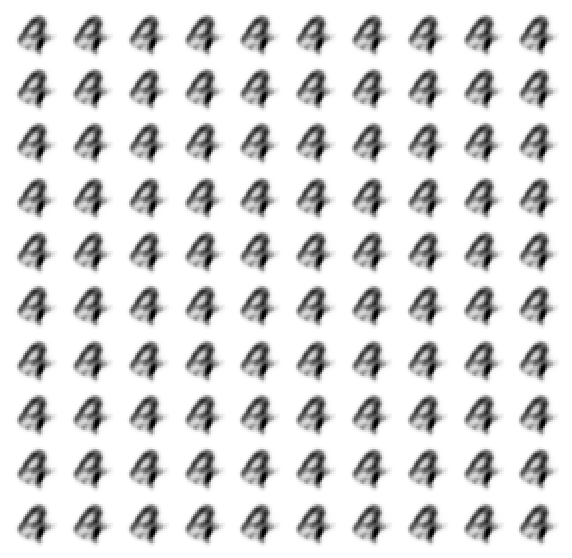

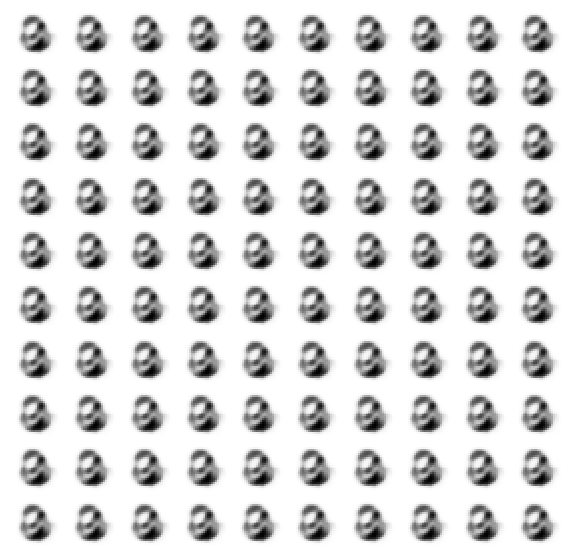

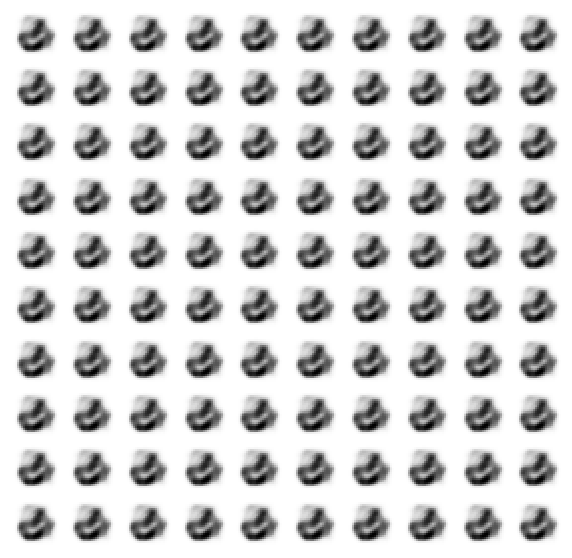

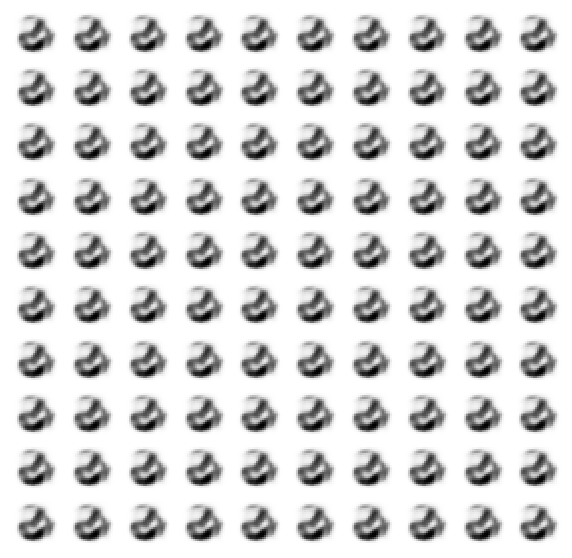

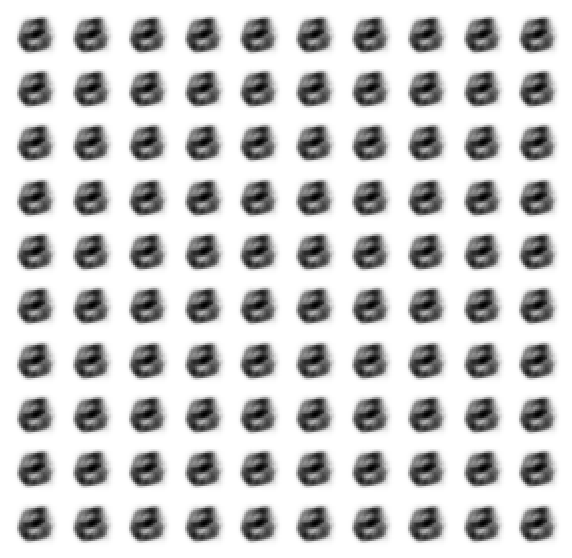

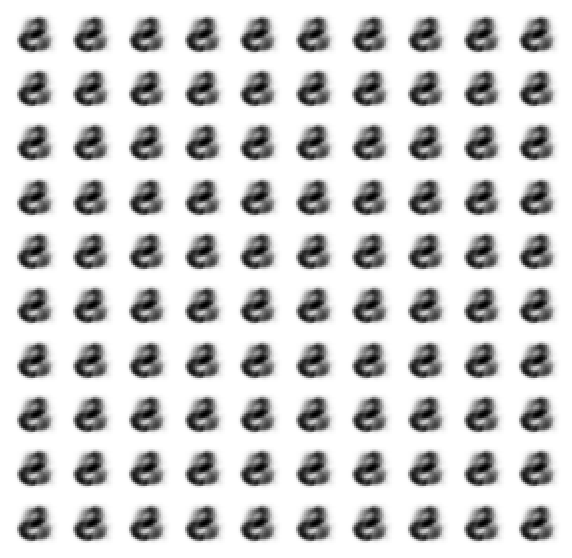

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(15):
    fig, axes = plt.subplots(10, 10, figsize=(10,10))
    for ax in axes.reshape((-1,)):
        ax.imshow(lattice_recon[i][k].reshape((28,28)), cmap="Greys", aspect="auto")
        ax.axis('off')
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()